In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import datasets, layers, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

### Load Dataset

Both the training and test datasets are directly loaded from Tensorflow.

In [9]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Check an example of the label to see if encoded or sparse.
print(y_train[0])

5


### Display Sample Inputs

This is just a sanity check on the kind of data in the dataset and also that the labels correspond to the images.

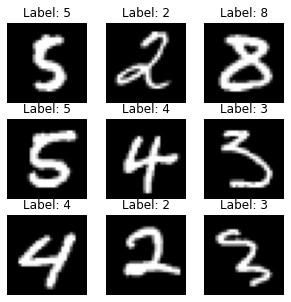

In [10]:
figure = plt.figure(figsize=(5, 5))

random_indices = random.sample(range(0, len(x_train)), 9)
for plot_index, image_index in enumerate(random_indices):
    random_image = x_train[image_index]
    plt.subplot(3, 3, (plot_index + 1))
    plt.imshow(random_image, cmap="gray")
    plt.axis("off")
    plt.title(f"Label: {y_train[image_index]}")

plt.show()

### Add Padding and Convert to RGB

Since I'm finetuning the model, the input images also need to conditioned to meet the expectations of the model input. In the case of ResNet50, the input_shape needs to have exactly 3 input channels and the input width and height need to be larger than 32.

We observe that the images in this dataset are grayscale and are of size 28x28. Hence, this is where padding and conversion to RGB are applied.

Using tf.pad below, the function takes in the entire inputs and adds a padding of 2 before and after the width and height, making the final new image a size of 32x32. They are also filled with constants of 0 which would essentially expand the black borders of the image. In order to convert the image into RGB, tf.repeat is used to convert the image into a 3 channel image (grayscale -> RGB would mean that each pixel has the same values across the 3 channels)

[TF ResNet50 Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)

[tf.pad Documentation](https://www.tensorflow.org/api_docs/python/tf/pad)

[tf.repeat Documentation](https://www.tensorflow.org/api_docs/python/tf/repeat)

New x_train shape:  (60000, 32, 32, 3)
New x_test shape:  (10000, 32, 32, 3)
Sample image after adding padding and converting to RGB:


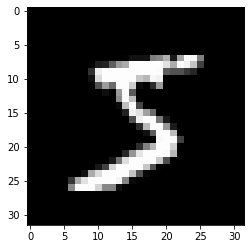

In [11]:
# Safety check to prevent overexpansion if the cell is accidentally run multiple times.
if x_train[0].shape != (32, 32, 3):
    # Normalize the values between 0 and 1
    x_train = tf.pad(x_train, [[0,0], [2,2], [2,2]]) / 255
    x_train = tf.expand_dims(x_train, 3)
    x_train = tf.repeat(x_train, 3, 3)

if x_test[0].shape != (32,32, 3):
    x_test = tf.pad(x_test, [[0,0], [2,2], [2,2]]) / 255
    x_test = tf.expand_dims(x_test, 3)
    x_test = tf.repeat(x_test, 3, 3)

print("New x_train shape: ", x_train.shape)
print("New x_test shape: ", x_test.shape)

plt.imshow(x_train[0])
print("Sample image after adding padding and converting to RGB:")
plt.show()

### Data Augmentation

Since the app I'm intending to use this model in enables the user to input images that aren't as consistent as the original dataset (eg. the digits can be drawn smaller, bigger, rotated, skewed and so on), I decided to try data augmentation techniques. These steps would enable the model to learn about these conditions without depending on the examples to exist in the original dataset.

[Keras ImageDataGenerator Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

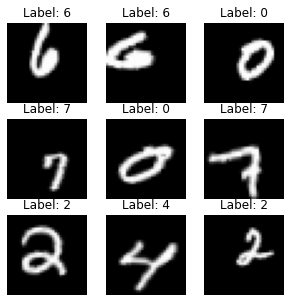

In [12]:
shift = 0.2
zoom_range = [0.5, 1.5]
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift, zoom_range=zoom_range, rotation_range=15, validation_split=0.2)

datagen.fit(x_train)
figure = plt.figure(figsize=(5, 5))

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
	# Show a sample of the first 9 images.
	for i in range(0, 9):
		plt.subplot(3, 3, (i + 1))
		plt.imshow(x_batch[i])
		plt.axis("off")
		plt.title(f"Label: {y_batch[i]}")

	plt.show()
	break

### Model Definition and Finetuning

In [13]:
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(32,32,3))

for layer in base_model.layers:
    layer.trainable = False

new_top = layers.Flatten()(base_model.output)
new_top = layers.Dense(1000, activation="relu")(new_top)
new_output = layers.Dense(10, activation="softmax")(new_top)

final_model = Model(inputs=base_model.input, outputs=new_output)
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Compiling the Model and Training

In [14]:
final_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = final_model.fit(datagen.flow(x_train, y_train, batch_size=32, subset="training"), 
                        validation_data=datagen.flow(x_train, y_train, batch_size=8, subset="validation"),
                        batch_size=32, 
                        epochs=10)

Epoch 1/10
1500/1500 [==============================] - 305s 201ms/step - loss: 1.6019 - accuracy: 0.4458 - val_loss: 1.4885 - val_accuracy: 0.4800
Epoch 2/10
1500/1500 [==============================] - 304s 202ms/step - loss: 1.3391 - accuracy: 0.5400 - val_loss: 1.2785 - val_accuracy: 0.5672
Epoch 3/10
1500/1500 [==============================] - 301s 200ms/step - loss: 1.2469 - accuracy: 0.5719 - val_loss: 1.2355 - val_accuracy: 0.5734
Epoch 4/10
1500/1500 [==============================] - 301s 201ms/step - loss: 1.1976 - accuracy: 0.5901 - val_loss: 1.1721 - val_accuracy: 0.6020
Epoch 5/10
1500/1500 [==============================] - 190s 127ms/step - loss: 1.1436 - accuracy: 0.6079 - val_loss: 1.1669 - val_accuracy: 0.5992
Epoch 6/10
1500/1500 [==============================] - 179s 119ms/step - loss: 1.1018 - accuracy: 0.6240 - val_loss: 1.1107 - val_accuracy: 0.6208
Epoch 7/10
1500/1500 [==============================] - 179s 120ms/step - loss: 1.0699 - accuracy: 0.6341 - val_

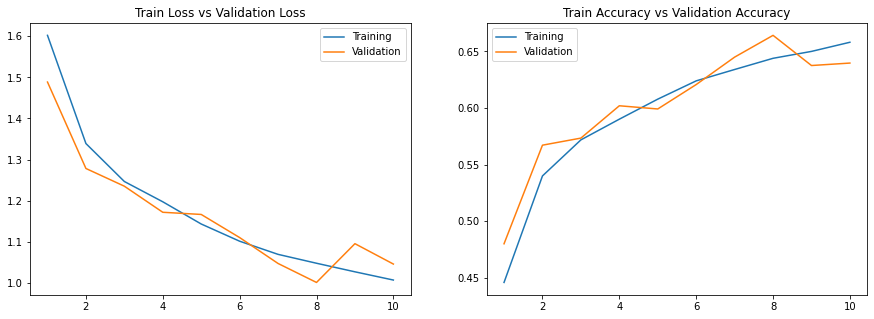

In [29]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

epochs = [i for i in range(1, history.params["epochs"] + 1)]

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.title("Train Loss vs Validation Loss")
plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy)
plt.plot(epochs, val_accuracy)
plt.title("Train Accuracy vs Validation Accuracy")
plt.legend(["Training", "Validation"])

plt.show()

### Model Evaluation

In [15]:
final_model.evaluate(x_test, y_test)
y_pred = np.argmax(final_model.predict(x_test), axis=1)

313/313 [==============================] - 33s 101ms/step - loss: 0.6676 - accuracy: 0.7797


[0.6676335334777832, 0.779699981212616]

              precision    recall  f1-score   support

           0       0.96      0.71      0.81      1330
           1       0.97      0.97      0.97      1142
           2       0.68      0.93      0.79       757
           3       0.64      0.91      0.75       710
           4       0.63      0.96      0.76       640
           5       0.54      0.78      0.64       609
           6       0.85      0.93      0.89       885
           7       0.82      0.90      0.86       941
           8       0.88      0.48      0.62      1768
           9       0.78      0.65      0.71      1218

    accuracy                           0.78     10000
   macro avg       0.78      0.82      0.78     10000
weighted avg       0.81      0.78      0.78     10000



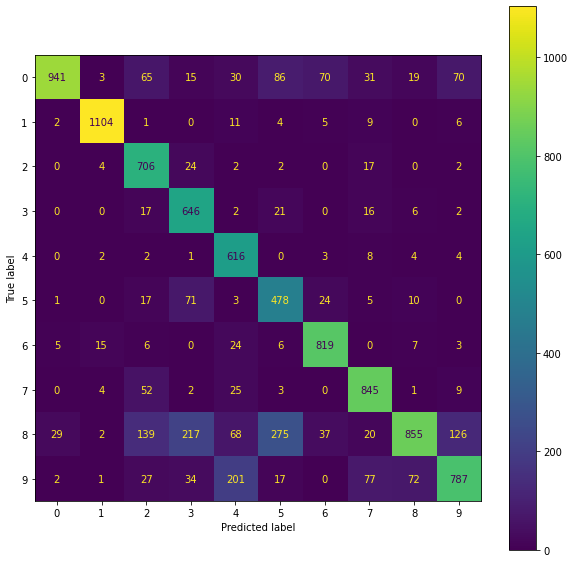

In [32]:
cr = classification_report(y_pred, y_test)
cm = confusion_matrix(y_pred, y_test)

fig, ax = plt.subplots(figsize=(10,10))
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(ax=ax)

print(cr)
plt.show()

In [17]:
model_dt = datetime.now().strftime("%d%m%YT%H%m")

final_model.save(f"tf_r50_{model_dt}")

INFO:tensorflow:Assets written to: tf_r50_28112021T1311\assets


C:\Users\Naim\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
